### Mount Google Drive containing checkpoints

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install the package

In [2]:
! pip install git+https://github.com/divamgupta/image-segmentation-keras

  Cloning https://github.com/divamgupta/image-segmentation-keras to /tmp/pip-req-build-16k8u894
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-16k8u894
     |████████████████████████████████| 3.3MB 20.7MB/s 
     |████████████████████████████████| 952kB 51.3MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp37-none-any.whl size=34545 sha256=8eb8710090bf7a7e863dbd15f9a0483fa3ee930a81c754820d9aeb810d73abca
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgw86mfj/wheels/a8/be/2c/1e1f0a75330e3ae33dd34c2ba085929eb7c7ae1d2184f4b7b5
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully unin

In [3]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=64999fedcc585b981d76b1e4d4bdb6b928a084b9d88270baf2438211d1f9dbe9
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [4]:
%load_ext memory_profiler

### Download the dataset

In [5]:
# new dataset
!wget "https://queensuca-my.sharepoint.com/:u:/g/personal/16drp4_queensu_ca/redacted?download=1" -O /content/dataset.zip
!unzip "/content/dataset.zip" -d "/content/"
# !mv /content/dataset-mapillary-vistas-v2/ /content/dataset
!mv /content/dataset-mapillary-vistas-v3/ /content/dataset

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset-mapillary-vistas-v3/training/images/A8-CU4vnQPCAPLstFCkcoA.png  
  inflating: /content/dataset-mapillary-vistas-v3/training/images/a8QM9l3AJkQvTGbg57XZmw.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/a8xUFTQTLJVYzvPoto-NTQ.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/aAXgEUbtUDgFzDiaIBy3gw.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/AayViGQnP34tZhlqif62Ow.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/AB1eaR9h32xRyOop-l3zuA.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/ADfGpdy7m6g6dgDJWHom1Q.png  
  inflating: /content/dataset-mapillary-vistas-v3/training/images/aEQC2qt5RDzFgEyxx6_Vzw.png  
  inflating: /content/dataset-mapillary-vistas-v3/training/images/aeX1J8TTqo2zubplWFkupQ.png  
 extracting: /content/dataset-mapillary-vistas-v3/training/images/Af-l0psNEEaI4MUDsRNgrg.png  

### Configure test params

In [6]:
%%memit
import os
import os.path
import glob
import random

from keras_segmentation.predict import predict
import tqdm.notebook as tq
import cv2
from google.colab.patches import cv2_imshow as imshow
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


peak memory: 404.93 MiB, increment: 289.73 MiB


In [7]:
TEST_ROOT_PATH = "/content/dataset/validation/" #@param {type:"string"}
TEST_SOURCES_PATH = os.path.join(TEST_ROOT_PATH, "images")
TEST_LABELS_PATH = os.path.join(TEST_ROOT_PATH, "labels")
ANSWER_KEY_CLASS = 1 # 0=background, 1=billboard


### Load saved model

In [8]:
%%memit
from keras_segmentation.predict import model_from_checkpoint_path
model_path = "/content/drive/MyDrive/Masters/models/segnet/model" #@param {type:"string"}
model = model_from_checkpoint_path(model_path)

loaded weights  /content/drive/MyDrive/Masters/models/segnet/model.00005
peak memory: 963.32 MiB, increment: 558.32 MiB


### Prep test data

In [9]:
%%memit
sources = []
labels = []
extensions = ["jpg", "jpeg", "png"]

for ext in extensions:
  sources+=glob.glob(os.path.join(TEST_SOURCES_PATH, "*."+ext))
  labels+=glob.glob(os.path.join(TEST_LABELS_PATH, "*."+ext))
sources = sorted(sources)
labels = sorted(labels)
print(f"Found {len(sources)} sources with {len(labels)} labels.")

Found 880 sources with 880 labels.
Found 880 sources with 880 labels.
Found 880 sources with 880 labels.
peak memory: 963.76 MiB, increment: 0.29 MiB


### Evaluate

In [15]:
%%memit
predict(model=model, inp=random.choice(sources))

peak memory: 3718.53 MiB, increment: 0.00 MiB


In [11]:
%%timeit -n 100 -r 5
predict(model=model, inp=random.choice(sources))

100 loops, best of 5: 103 ms per loop


In [20]:
cm = np.zeros((2,2))

for source, label in tq.tqdm(zip(sources, labels), total=len(sources)):
  prediction = predict(
      model=model,
      inp=source,
      out_fname="/content/out.png"
  )
  # guesses = prediction[:,:] == ANSWER_KEY_CLASS
  
  answer = cv2.imread(label) # read answer key (BGR by default)
  answer = cv2.resize(answer, prediction.shape[::-1], cv2.INTER_NEAREST) # shrink to match prediction output
  answer = answer[:,:,0] # grab answers from blue channel

  cm_ = confusion_matrix(answer.ravel(), prediction.ravel())
  assert cm_.shape == (2,2)
  cm += cm_

print(cm.tolist())

AssertionError: ignored

DICE = 0.9995096826044385
JAC = 0.9990198457955339
Recall = 0.9993067463224813
Specificity = 0.9385749790147637
Fallout = 0.06142502098523628
FNR = 0.0006932536775187126
Precision = 0.999712701326547
F1-Measure = 0.9995096826044386


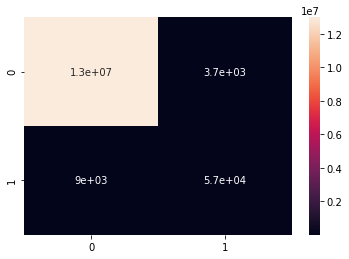

In [13]:
sns.heatmap(cm, annot=True)

TP = cm[0][0]
FP = cm[0][1]
TN = cm[1][1]
FN = cm[1][0]

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4533825/

DICE = 2*TP / (2 * TP + FP + FN)
print(f"DICE = {DICE}")

JAC = TP / ( TP + FP + FN)
print(f"JAC = {JAC}")

TPR = TP / (TP + FN)
print(f"Recall = {TPR}")

TNR = TN / (TN + FP)
print(f"Specificity = {TNR}")

FPR = 1 - TNR
print(f"Fallout = {FPR}")

FNR = 1 - TPR
print(f"FNR = {FNR}")

PPV = TP / (TP + FP)
print(f"Precision = {PPV}")

FMS = (2 * PPV * TPR) / (PPV + TPR)
print(f"F1-Measure = {FMS}")


### Performance analysis

In [19]:
%%timeit
for source, label in tq.tqdm(zip(sources, labels), total=len(sources)):
  prediction = predict(
      model=model,
      inp=source,
      out_fname="/content/out.png"
  )


1 loop, best of 5: 34.8 s per loop


In [22]:
%memit
for source, label in tq.tqdm(zip(sources, labels), total=len(sources)):
  prediction = predict(
      model=model,
      inp=source,
      out_fname="/content/out.png"
  )

peak memory: 4322.82 MiB, increment: 0.01 MiB


In [10]:
%memit print("test")

test
test
test
test
test
test
test
peak memory: 150.35 MiB, increment: 0.00 MiB
